# Выявление профилей потребления интернет-магазина "Пока все еще тут"

Необходимо провести категоризацию товаров и сегментировать покупателей по профилю потребления. Разработать рекомендации по выставлению персональных предложений для каждого сегмента.

## Предобработка данных.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
import requests
from bs4 import (BeautifulSoup,)
from scipy import stats
from scipy import stats as st
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

In [2]:
url = 'https://drive.google.com/file/d/1uK451bMdYTZ2r4KE7pLcDYqU80eyDABa/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

In [3]:
url1 = 'https://drive.google.com/file/d/14VAVrtVYrYR4mj7VOjboWl3CR1ZslLp_/view?usp=sharing'
path1 = 'https://drive.google.com/uc?export=download&id='+url1.split('/')[-2]
category = pd.read_csv(path1, sep = ';',engine='python', encoding='cp1251')

Импортируем основные библиотеки и прочтем датасеты.

In [4]:
df.sample()

,date,customer_id,order_id,product,quantity,price
3560,2019051219,3d5fef90-4a65-4a7e-84cf-010eba7b038d,14753,Дыня Медовый Спас d-7 см раннеспелая,1,30.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


Выведем информацию о датасете и типах полей. На первый взгляд все поля имеют корректный и подходящий для содержимого формат кроме поля date. Требуется приведение поля date к типу даты-времени.

In [6]:
df.columns = map(str.lower, df.columns)

Приведем буквы в заголовках столбцов к строчным.

In [7]:
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d%H')
df['event_date'] = df['date'].astype('datetime64[D]')
df['event_month'] = df['date'].astype('datetime64[M]')

In [8]:
df.sample()

,date,customer_id,order_id,product,quantity,price,event_date,event_month
6327,2019-09-14 14:00:00,33867e5a-f275-461f-81ef-f4414bb0a7d7,72628,"Гладильная доска НИКА БЭЛЛЬ 106,5х29 см Б",1,562.0,2019-09-14,2019-09-01


Приведем дату к формату даты - времени (часа) и добавим поле event_date с датой без времени.

In [9]:
cols = df.columns[:6]
for col in df.columns:
    pct_missing = np.mean(df[col].isna())
    print('{} - {}%'.format(col, pct_missing*100))

date - 0.0%
customer_id - 0.0%
order_id - 0.0%
product - 0.0%
quantity - 0.0%
price - 0.0%
event_date - 0.0%
event_month - 0.0%


Проверим поля на пропущенные значения. Проверка показала, что пропусков нет.

In [10]:
df.duplicated().sum()

0

Проверим датасет на дублирующиеся строки. Полных дубликатов строк нет.

In [11]:
df['date'].describe()

count                    6737
unique                   2606
top       2019-04-27 16:00:00
freq                       51
first     2018-10-01 00:00:00
last      2019-10-31 16:00:00
Name: date, dtype: object

Данные о покупках в датасете - с 1 октября 2018 по 31 октября 2019.

## Категоризация товарной номенклатуры.

In [12]:
prod_lst=df['product'].unique().tolist()

In [13]:
len(prod_lst)

2343

Посчитаем количество уникальных наименований в поле product. Их 2 343. Вручную категоризовать такое количество SKU некорректно и очень трудоемко.

In [14]:
df['product']=df['product'].str.lower()

Приведем наименования товаров к нижнему регистру для частичной унификации.

In [15]:
df.pivot_table(index = 'product', values = 'quantity', aggfunc = 'sum').reset_index().sort_values(by = 'quantity', ascending = False)

,product,quantity
112,"вантуз с деревянной ручкой d14 см красный, bur...",1000
829,муляж яблоко 9 см красное,618
185,вешалки мягкие для деликатных вещей 3 шт шоколад,335
657,"крепеж для пружины дверной, 1107055",320
831,муляж яблоко зеленый 9 см полиуретан,308
...,...,...
1116,подвесное кашпо гелихризум серебристая объем 4 л,1
1111,подарочный набор на 8 марта пеларгония белая d...,1
1103,плед флисовый 150х130 см wellness wplny135-зим...,1
1102,плед флисовый 100% полиэстер 185х240 см бежевы...,1


Унифицировалось только одно наименование, теперь в датасете 2 341 уникальное наименование.

In [16]:
def first_word(row):
    word = row['product']
    
    return re.search('\w+', word).group()
        
df['first_word'] = df.apply(first_word, axis = 1)

Отделим первое слово в наименовании товара и запишем его в столбец first_word.

In [17]:
len(df['first_word'].unique())

443

Посчитаем количество уникальных наименований из первых слов названия товара. Их 443. Данное количество позволяет позволяет распределить категории вручную. Воспользуемся сайтом OBI и с его помощью присвоим категории для первых слов в наименовании, записав справочник "первое слово наименования - категория" в файл xlsx. После присвоения категорий переведем файл category в csv и прочтем.  

In [18]:
df.head(3)

,date,customer_id,order_id,product,quantity,price,event_date,event_month,first_word
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01,2018-10-01,комнатное
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01,2018-10-01,комнатное
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018-10-01,радермахера


In [19]:
category['first_name_word'] = category['first_name_word'].str.lower()
category.head(5)

,first_name_word,category,category_big
0,комнатное,растения,растения
1,радермахера,растения,растения
2,хризолидокарпус,растения,растения
3,циперус,растения,растения
4,шеффлера,растения,растения


Приведем наименования в файле category к строчным буквам.

In [20]:
df = df.merge(category, left_on ='first_word', right_on = 'first_name_word', how = 'left')
df.sample(3)

,date,customer_id,order_id,product,quantity,price,event_date,event_month,first_word,first_name_word,category,category_big
4719,2019-06-06 13:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"рассада кабачка сорт горный, кассета по 6шт",1,120.0,2019-06-06,2019-06-01,рассада,рассада,растения,растения
4053,2019-05-27 13:00:00,bebc738a-dfd3-4763-841b-b529504ce8de,71524,тележка багажная delta тбр-20 синий грузоподъе...,1,734.0,2019-05-27,2019-05-01,тележка,тележка,садовый и строительный инвентарь,сад
958,2018-11-24 09:00:00,e72fcd9e-d3d0-4a40-8910-6bce6e794aed,69104,набор стаканов для виски 300 мл 6 шт серия кар...,1,239.0,2018-11-24,2018-11-01,набор,набор,прочее,прочее


In [21]:
df['category'].isna().sum()

0

Объединим основной датасет и справочник категорий. Проверим, нет ли пропусков в поле category. Пропусков 0, категории подтянулись все.

In [22]:
cat = df['category'].unique().tolist()

In [23]:
cat_big = df['category_big'].unique().tolist()

In [24]:
df['summ'] = df['quantity']*df['price']

Добавим столбец с общей стоимостью заказа.

## Исследовательский анализ данных

In [25]:
uni_customer = len(df['customer_id'].unique())
uni_customer

2451

В датасете - данные о покупках 2 451 уникального покупателя.

In [26]:
events = len(df['customer_id'])
events

6737

In [27]:
avg_sales_per_user = events/uni_customer
round(avg_sales_per_user,2)

2.75

В датафрейме - информация о 6737 покупках. В среднем на одного покупателя приходится 2,75 покупки. Эта информация понадобится нам в дальнейшем для сравнения средних покупок каждого сегмента с общим средним количество м покупок.

In [28]:
#plt.figure(figsize=(6,6))
#sns.histplot(df['event_month'], binwidth=0.5)
#plt.xlabel("Месяц")
#plt.ylabel("Количество")
#plt.xticks(rotation=90, fontsize =10)
#plt.title('Распределение покупок помесячно', fontsize = 14);

Построим график распределений количества покупок по месяцам. Закономерно выглядит спад продаж в январе. Аномально выглядит июньский пик, проанализируем его отдельно. 

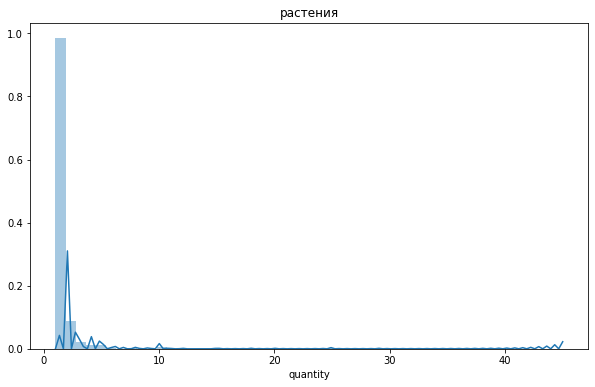

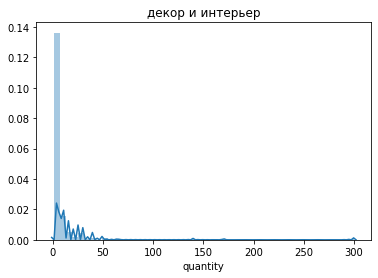

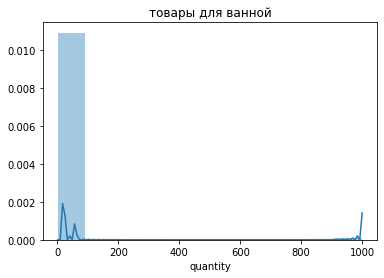

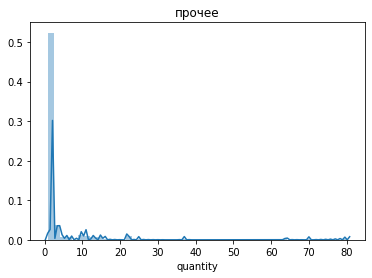

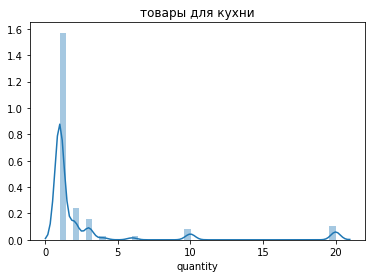

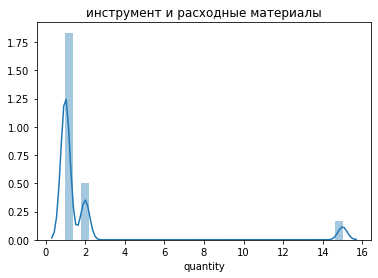

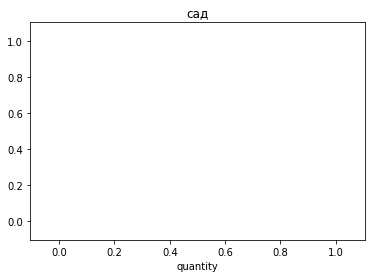

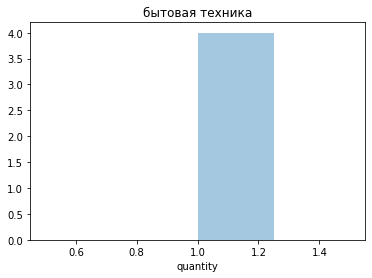

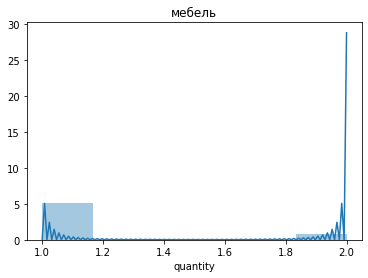

In [29]:
warnings.simplefilter('ignore')
plt.figure(figsize=(10, 6))
for el in cat_big:
    sns.distplot(df.query('category==@el')['quantity'])
    plt.title(el)    
    plt.show()

Проанализируем количественные распределения каждой категории. Закономерно выглядит близкая к единице максимальная плотность распределения для всех категорий, обычно в магазинах направления "товары для дома" покупают 1-2 единицы товара. Закономерно выглядят неравномемрности распределений категорий "инструмент и расходные материалы", они обусловлены спецификой товара, покупка большого количества расходных материалов часто практикуется.

In [30]:
sales_by_cat = df.pivot_table(index = 'category_big', values = ['quantity', 'summ'], aggfunc = 'sum').reset_index()

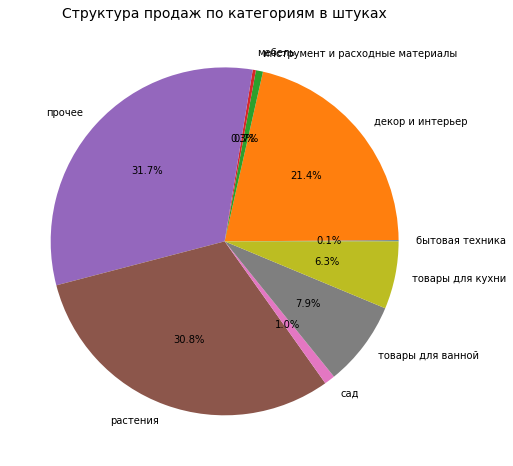

In [31]:
pie, ax = plt.subplots(figsize=[8,8])    
plt.pie(x=sales_by_cat['quantity'], autopct="%.1f%%",labels = sales_by_cat['category_big'])
plt.title("Структура продаж по категориям в штуках", fontsize=14);
#plt.savefig('struct_qty.png', transparent=True)

Проанализируем  общие продажи по категориям(количество). Большую долю продаж занимают растения (33,5%). Далее - категория "прочее", 29,9%. Третью позицию занимает категория "декор и интерьер", 23,4%. Товары для кухни занимают 4 место, 8,5%. Доля остальных категорий в совокупности не более 4%. Это обусловлено тем, что анализируются количественные значения.

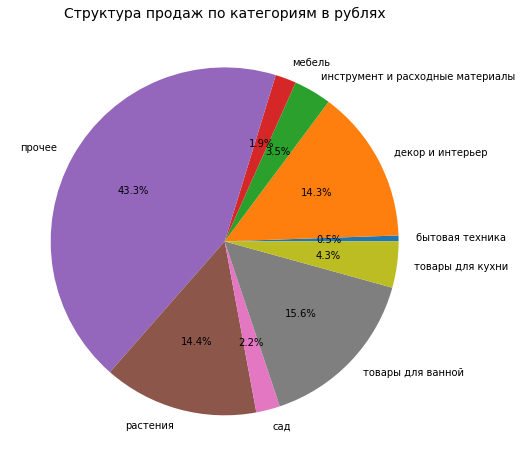

In [32]:
pie, ax = plt.subplots(figsize=[8,8])    
plt.pie(x=sales_by_cat['summ'], autopct="%.1f%%",labels = sales_by_cat['category_big'])
plt.title("Структура продаж по категориям в рублях", fontsize=14);
#plt.savefig('struct_summ.png', transparent=True)

Проанализируем структуру продаж в разрезе категорий в рублях. Товары категории "Прочее" - на первом месте с долей 46,4%. Далее - товары категории "декор и интерьер", 17,5%. Доля растений  - третья, 17,1%. Следующая категория - товары для кухни, 6,5%. Прочие категории занимают долю от 0,6 до 4,4%. Вывод - ассортимент магазина в большей степени представлен хозтоварами, растениями, товарами для декора и интерьера и товарами для кухни.

In [33]:
sales_by_customers = df.groupby(['order_id','event_date','customer_id'])['summ'].sum().reset_index()

Сгруппируем продажи по id покупателя, id заказа и дате покупки, чтобы получить датафрейм с разовыми покупками и заказами в разрезе клиентов.

In [34]:
sales_by_customers['summ'].describe()

count      3169.000000
mean       1530.855159
std       12178.918738
min          14.000000
25%         299.000000
50%         728.000000
75%        1547.000000
max      675000.000000
Name: summ, dtype: float64

Сформируем распределение разовых покупок. Средняя сумма покупки на покупателя - 1618 рублей. Медиана - 742 рубля. Стандартное отклонение - 12 541 руб. Большая разница между медианой и средним говорит о том, что данные неоднородны и есть крупные покупки, влияющие на среднее значение. Третий квартиль - на уровне 1 612 руб.

In [35]:
sales_by_customers

,order_id,event_date,customer_id,summ
0,12624,2019-06-02,d17861fa-db5f-4de4-93fd-dc5e60d24d3e,375.0
1,13547,2018-10-05,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,684.0
2,13547,2018-10-23,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,684.0
3,13547,2018-10-28,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,684.0
4,13547,2018-11-02,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,684.0
...,...,...,...,...
3164,73155,2019-10-31,f17ed857-178e-45e1-a662-0a9dd3b58c5f,329.0
3165,73156,2019-10-31,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,404.0
3166,73158,2019-10-31,1f0a7f35-7459-4f23-b468-5e45bf481dd1,1087.0
3167,73162,2019-10-31,25df96a7-c453-4708-9cea-a3dfc7c342ea,157.0


In [36]:
sales_by_customers.sample()

,order_id,event_date,customer_id,summ
1647,70589,2019-03-04,c971fb21-d54c-4134-938f-16b62ee86d3b,374.0


In [37]:
sales_by_customers['date_num'] = sales_by_customers['event_date'].astype(int)

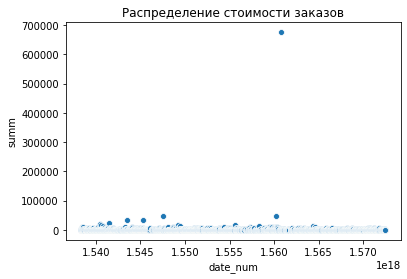

In [38]:
sns.scatterplot(x = 'date_num', y = 'summ',data = sales_by_customers)
plt.title('Распределение стоимости заказов');

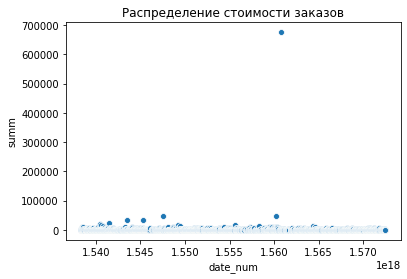

In [39]:
sns.scatterplot(x = 'date_num', y = 'summ',data = sales_by_customers)
plt.title('Распределение стоимости заказов');

Сформируем точечную диаграмму распределения разовых покупок. На диаграмме видно, что основная плотность приходится на заказы до 4 000 руб. Но и до 6 000 достаточно много заказов. Предлагается сегментировать покупателей по заказам, суммой не более 6 000 руб.

In [40]:
anomal_transaction_lst = sales_by_customers.query('summ>6000')['order_id'].unique().tolist()

Сформируем список заказов, в которых есть аномально большие транзакции (на предыдущей итерации проекта мы определили, что это транзакции, суммой больше 6000)

In [41]:
sales_by_customers = sales_by_customers.query('order_id not in @anomal_transaction_lst')

Отфильтруем эти заказы целиком

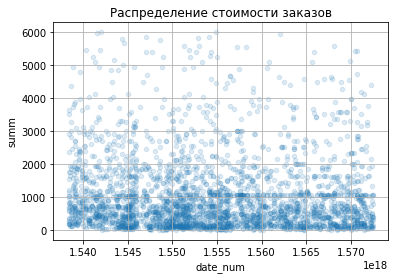

In [42]:
sales_by_customers.plot(x = 'date_num', y = 'summ', kind = 'scatter', grid = True,alpha=0.15)
plt.title('Распределение стоимости заказов');
#plt.savefig('dist_sum.png', transparent=True)

In [43]:
cust_qty = sales_by_customers.groupby(['customer_id']).agg({'order_id':'nunique'}).reset_index()

In [44]:
cust_qty.describe()

,order_id
count,2390.000000
mean,1.147280
std,2.655318
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,125.000000


Оптовые клиенты могут исказить картину при последующей сегментации, т.к. потребительское поведение розничных и оптовых клиентов различается. Также персональные предложения некорректно будет формировать для сегментов со смешанными оптово-розничными клиентами, для оптовых покупателей не подойдут персонифицированные предложения для розничных клиентов. Чтобы выявить оптовых клиентов, проанализируем датасет среднего заказа за весь период (с учетом фильтрации датасета по заказам больше 6 000). Если за год покупатель делал определенное количество заказов, с большей долей вероятности его можно отнести к оптовым клиентам.

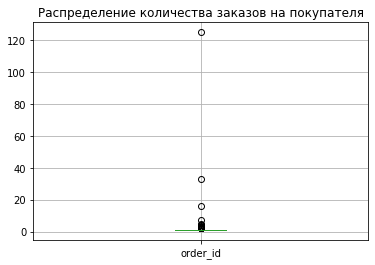

In [45]:
cust_qty.boxplot(column = 'order_id')
plt.title('Распределение количества заказов на покупателя');
#plt.savefig('dist_orders.png', transparent=True)

Распределение показывает, что линия до 8 заказов на боксплоте непрерывна. Далее - небольшой непрерывный сегмент по 10-12 заказов в год. Выше - аномально большие заказы. Предлагается отфильтровать пользователей с заказами более 10, как оптовых.

In [46]:
sum_retail_customers = sales_by_customers['customer_id'].unique().tolist()

Сформируем список id клиентов с разовыми заказами менее 6000.

In [47]:
qty_retail_customers = cust_qty.query('order_id<10')['customer_id'].unique().tolist()

Сформируем список id клиентов с количеством, не более 10 заказов в год.

In [48]:
final_client_lst= list(set(sum_retail_customers) & set(qty_retail_customers))#sum_retail_customers + qty_retail_customers

Объединим списки по пересечению (только те id, которые есть в обоих списках)

In [49]:
res = np.array(final_client_lst)
final_client_lst = np.unique(res)

Сформируем список уникальных id (без повторов)

In [50]:
uni_customer - len(final_client_lst)

64

В процессе нормализации данных были отфильтрованы данные о продажах 64 покупателям.

In [51]:
df = df.query('customer_id in @final_client_lst')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5270 entries, 0 to 6736
Data columns (total 13 columns):
date               5270 non-null datetime64[ns]
customer_id        5270 non-null object
order_id           5270 non-null int64
product            5270 non-null object
quantity           5270 non-null int64
price              5270 non-null float64
event_date         5270 non-null datetime64[ns]
event_month        5270 non-null datetime64[ns]
first_word         5270 non-null object
first_name_word    5270 non-null object
category           5270 non-null object
category_big       5270 non-null object
summ               5270 non-null float64
dtypes: datetime64[ns](3), float64(2), int64(2), object(6)
memory usage: 576.4+ KB


In [104]:
df.head()

,date,customer_id,order_id,product,quantity,price,event_date,event_month,first_word,first_name_word,category,category_big,summ,cluster_km
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01,2018-10-01,комнатное,комнатное,растения,растения,142.0,0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01,2018-10-01,комнатное,комнатное,растения,растения,194.0,0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018-10-01,радермахера,радермахера,растения,растения,112.0,0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10-01,2018-10-01,хризолидокарпус,хризолидокарпус,растения,растения,179.0,0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10-01,2018-10-01,циперус,циперус,растения,растения,112.0,0


Выведем информацию об отфильтрованном датасете. В результате фильтрации количество строк сократилось с 6736 до 5270.

## Сегментация пользователей.

In [53]:
scaler = StandardScaler()

Проведем обязательную стандартизацию перед работой с алгоритмамти кластеризации.

In [54]:
df_cluster = df.pivot_table(index = ['customer_id','category_big'], values = ['quantity', 'summ'], aggfunc = 'sum').reset_index()

Сформируем датасет для кластеризации, содержащий только необходимые поля (сгруппированные по id клиента и категории, категорию и количество приобретенного товара)

In [55]:
df_dummed = pd.get_dummies(df_cluster, columns=['category_big'])
df_dummed.shape[0]

2471

Для последующей кластеризации клиентов переведем категориальный признак 'category_big' в бинарный. Применим стандартизацию one-hot encoding, она представит поле "категория" как множество бинарных полей.

In [56]:
cols = list(df_dummed.columns)
cols = cols[3:12]
for el in cols:
    df_dummed[el] = np.where((df_dummed[el] == 0), 0, df_dummed['quantity'])

После стандартизации one-hot encoding получены бинарные поля. Но для корректной кластеризации недостаточно бинарного признака, количество приобретенного товара важно для корректной сегментации клиентов. Запишем на место бинарных признаков количество единиц товара, чтобы алгоритм кластеризации мог бы учитывать веса, а не только факт покупки определенной категории товара. 

In [57]:
df_dummed.sample(5)

,customer_id,quantity,summ,category_big_бытовая техника,category_big_декор и интерьер,category_big_инструмент и расходные материалы,category_big_мебель,category_big_прочее,category_big_растения,category_big_сад,category_big_товары для ванной,category_big_товары для кухни
145,0efde029-f588-4d48-9a62-a90597443d0f,2,3298.0,0,0,0,0,2,0,0,0,0
1061,6f3534e1-6c25-4158-a342-874682a09aab,1,712.0,0,0,0,0,1,0,0,0,0
1939,caf8cd5f-f4ec-4bef-b5b2-4f4b61fb79a5,1,3524.0,0,0,0,0,1,0,0,0,0
2151,e012f706-9ba1-4482-8a9a-58d54e5c3a51,1,1087.0,0,0,0,0,1,0,0,0,0
2355,f39494d8-6341-4483-af44-6f3c53706c7b,1,134.0,0,0,0,0,0,1,0,0,0


In [58]:
df_dummed = df_dummed.groupby('customer_id').agg('sum').reset_index()

Сгруппируем датасет по id клиента.

In [59]:
X_sc = scaler.fit_transform(df_dummed.drop(columns = ['customer_id','summ','quantity'])) 

In [60]:
linked = linkage(X_sc, method = 'ward')

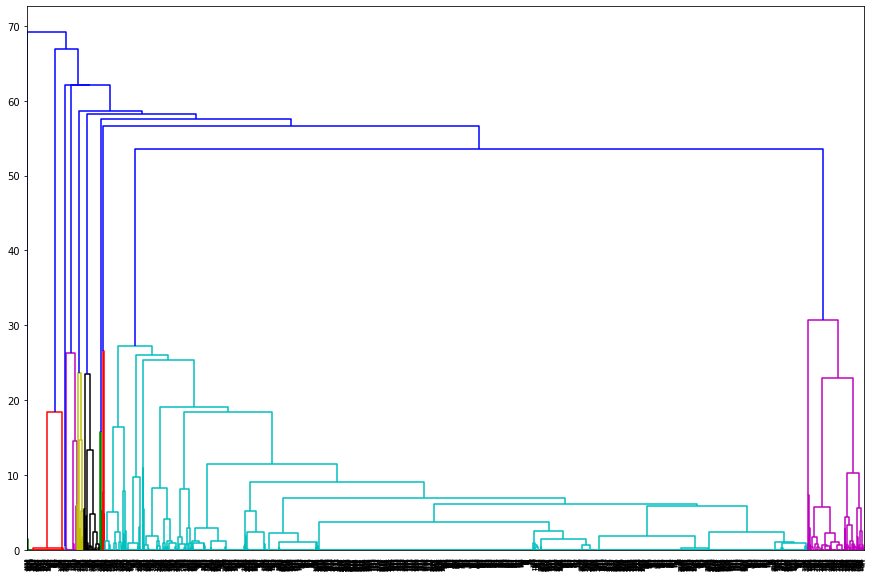

In [61]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Построим дендрограмму, чтобы оценить количество кластеров. На дендрограмме видно, что ненакладывающееся друг на друга количество кластеров - примерно 6.Предлагается использовать 6 кластеров для кластеризации k-Means. Впоследствии можно оценить метрику силуэта и проверить корректность выбора количества кластеров.

In [62]:
km = KMeans(n_clusters = 5, random_state = 0)

Зададим параметр n_clusters для k-means равный 5

In [63]:
labels = km.fit_predict(X_sc)

Спрогнозируем кластеры для наблюдений.

In [64]:
df_dummed['cluster_km'] = labels

Сохраним метки кластера в столбце cluster_km исходного датасета.

In [65]:
print('Метрика силуэта: {:.2f}'.format(silhouette_score(X_sc, labels)))

Метрика силуэта: 0.73


Посчитаем метрику силуэта для того, чтобы оценить качество кластеризации. Метрика силуэта интерпретируется следующим образом: чем ближе silhouette_score к 1, тем качественнее кластеризация, т.е. объект своего кластера похож на свой кластер больше, чем на чужой. В нашем слечае значение равно 0,74. Это может свидетельствовать о высоком качестве кластеризации.

In [66]:
print(df_dummed['cluster_km'].max())

4


In [67]:
df_dummed['cluster_km'].value_counts()

0    2242
1      92
4      33
2      17
3       3
Name: cluster_km, dtype: int64

Оценим наполнение кластеров по количеству клиентов

In [68]:
customer_cluster_lst = df_dummed.drop(columns = ['summ','quantity','category_big_бытовая техника','category_big_декор и интерьер','category_big_инструмент и расходные материалы','category_big_мебель','category_big_прочее','category_big_растения','category_big_сад','category_big_товары для ванной','category_big_товары для кухни'])
customer_cluster_lst.sample(5)

,customer_id,cluster_km
1777,bf7fa8ff-007a-41fa-a07e-f3cfb90aee36,0
2222,ef770989-4e4d-4f29-be2a-f7834846a483,0
1347,93548f94-40dc-4787-aef4-5da7f7058021,0
1667,b4d0da2e-e1c7-4470-922f-d7f9632aee0f,1
1406,98de0e2a-2e04-48de-a12c-c139394c8da4,0


Сформируем справочник соответствий покупателей и кластеров

In [69]:
df = df.merge(customer_cluster_lst, left_on ='customer_id', right_on = 'customer_id', how = 'left')

Объединим основной датасет и справочник кластеров

In [70]:
df.head(2)

,date,customer_id,order_id,product,quantity,price,event_date,event_month,first_word,first_name_word,category,category_big,summ,cluster_km
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01,2018-10-01,комнатное,комнатное,растения,растения,142.0,0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01,2018-10-01,комнатное,комнатное,растения,растения,194.0,0


In [71]:
clusters_df = (df.groupby('cluster_km').agg({'customer_id':'nunique', 'order_id':'nunique', 'quantity':'sum', 'summ':'sum'})).reset_index()
clusters_df=clusters_df.rename(columns = {'customer_id':'customers_qty', 'order_id':'orders_qty','summ':'revenue'})

In [72]:
clusters_df['avg_receipt_per_customer']=(clusters_df['revenue']/clusters_df['customers_qty']).round(1)
clusters_df['avg_orders_per_customer']=(clusters_df['orders_qty']/clusters_df['customers_qty']).round(1)
clusters_df['avg_qty_per_customer']=(clusters_df['quantity']/clusters_df['customers_qty']).round(1)
clusters_df

,cluster_km,customers_qty,orders_qty,quantity,revenue,avg_receipt_per_customer,avg_orders_per_customer,avg_qty_per_customer
0,0,2242,2391,11448,2840117.0,1266.8,1.1,5.1
1,1,92,97,105,83142.0,903.7,1.1,1.1
2,2,17,16,23,21071.0,1239.5,0.9,1.4
3,3,3,3,149,10796.0,3598.7,1.0,49.7
4,4,33,38,54,95480.0,2893.3,1.2,1.6


Сформируем датасет для анализа основных показателей в разрезе кластеров. Сгруппируем основной датасет по номеру кластера и посчитаем уникальное количество покупателей, заказов, суммарную выручку и количество средних заказов на кластер.

In [73]:
clusters_by_category = df.groupby(['cluster_km','category_big'])['quantity'].sum().reset_index()

Сформируем датасет для анализа кластеров в разрезе категорий.

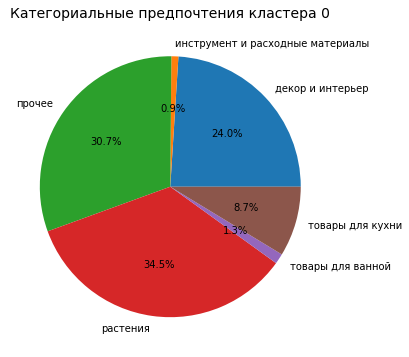

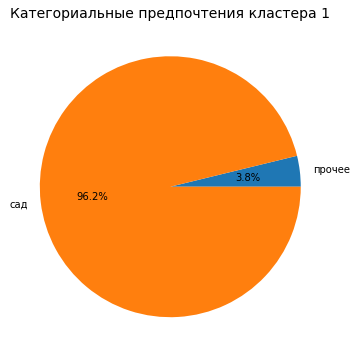

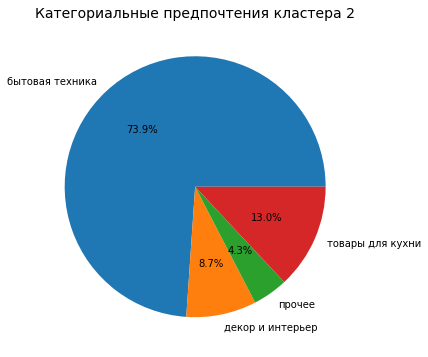

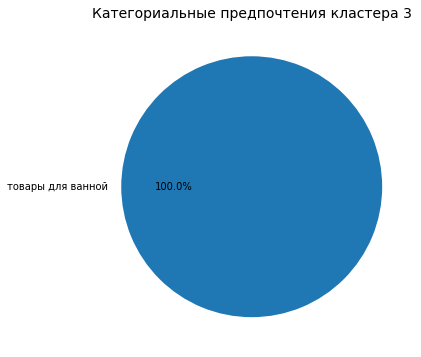

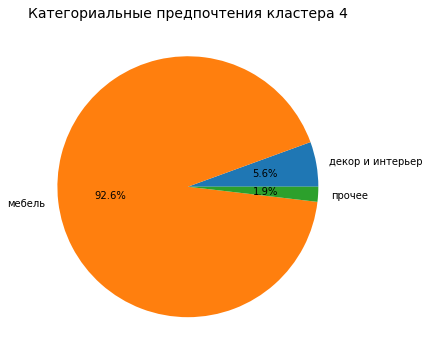

In [74]:
for i in range(0,5):
    pie, ax = plt.subplots(figsize=[10,6])    
    plt.pie(x=clusters_by_category.query('cluster_km==@i')['quantity'], autopct="%.1f%%",labels = clusters_by_category.query('cluster_km==@i')['category_big'])
    plt.title("Категориальные предпочтения кластера "+str(i), fontsize=14);
    #plt.savefig(str(i)+'segments.png', transparent=True)

Сформируем круговые диаграммы для каждого кластера с долями покупок по категориям.

Сделаем обзор кластеров и составим портреты покупателей для каждого кластера.

- Кластер 0 - самый многочисленный, число уникальных покупателей - 2171. Количество сделанных заказов - 2291, что составляет примерно 1,1 заказ на покупателя. Средний чек покупателя - 1215 руб, что является почти самым невысоким значением (за исключением среднего чека покупателя из кластера 4). Среднее количество позиций товара в заказе - 4,4 шт., это второй по величине показатель. Категорийные предпочтения покупателей этого кластера разнообразны. 37% заказов - из категории "прочее". В эту категорию входят некрупные товары повседневного спроса (бытовая химия, фурнитура и крепежи, уборочный инвентарь для дома и хозтовары). Следующая по величине категория - декор и интерьер, в которую входят уже более крупные и неповседневные покупки - освещение, коврики, шторы и карнизы, скатерти и текстиль для дома и искусственные декоративные растения. Эта категория занимает долю 28,4%. Далее следуют растения (20%), товары для кухни (10,5%) и товары для ванной (3,1%). Представленность в кластере всех категорий, количество покупателей в кластере, невысокий средний чек и количество позиций в заказе позволяют отнести покупателей этого кластера к сегменту "типичный повседневный разовый покупатель". Данный сегмент генерирует основную выручку магазина, но среднее количество заказов - 1,1 - не позволяет считать данного покупателя постоянным. Возможно, необходимы какие-либо маркетинговые мероприятия, чтобы убедить покупателей из этого сегмента делать повторные покупки, это благоприятно скажется на общей выручке магазина.

- Кластер 1 - достаточно немногочисленный, 74 покупателя. Средний чек этого кластера - 2865 руб, это один из самых высоких средних чеков. Количество заказов: 1,4 на покупателя, количество sku в заказе - 28,9 штук, самый высокий показатель. Лидирующая категория - растения, занимает 96,5% среди покупок кластера. По совокупности факторов типичный покупатель этого кластера похож на мелкооптового покупателя. Высокий средний чек и самое высокое значение количества заказов на покупателя позволяют считать клиента этого кластера постоянным и перспективным клиентом. Для увеличения выручки возможно будет целесообразно сделать персональное предложение о скидках за объем клиентам этого кластера.

- Кластер 2 - второй снизу по количеству покупателей, 33 покупателя. Генерируемая выручка - 95480 руб. Средний чек - самый высокий, 2893.3 руб. Количество заказов - 1,2 на покупателя. Среднее количество позиций в заказе на человека - 1,6. 96,2% покупок клиентами этого кластера - мебель. По совокупности характеристик можно отнести этот кластер к сегменту "разовые покупатели мебели". Возможно, будет целесообразно сделать покупателям данного кластера персональное предложение со скидкой мебели за вторую и последующую покупку.

- Кластер 3 - самый немногочисленный, содержит 17 покупателей. Количество заказов - 16. Ниже необходимо проверить данные, т.к. возможно изначальный датасет содержит неточность, если уникальных покупателей - 17, а заказов - 16, то один и тот же заказ проходит по двум покупателям, вряд ли это корректно. Выручка этого кластера самая маленькая, 21071 руб. Доминирующая категория - бытовая техника. Следующие категории в этом кластере - товары для кухни и декор и интерьер. Совокупность факторов позволяет идентифицировать этот сегмент покупателей как покупателей бытовой техники.

- Кластер 4 - второй по многочисленности, 92 покупателя. Выручка кластера - 83142 руб, но средний чек - самый низкий, 903 руб. Среднее количество покупок на клиента - 1,1. Доминирующая категория - товары для сада, 96,2%. По совокупности факторов можно идентифицировать данный сегмент как покупателей товаров для сада, не склонных к повторным покупкам. Возможно, имеет смысл сделать персональное предложение, стимулирующее клиентов данного кластера к повторным покупкам.

In [75]:
doubling_chsk = df.query('cluster_km==3').groupby(['customer_id']).sum()
doubling_chsk = doubling_chsk.groupby('order_id')['order_id'].count()
doubling_chsk

order_id
70970     1
138320    1
207441    1
Name: order_id, dtype: int64

Проверим кластер 3 на задвоение заказа. Видно, что заказ с номером 70542 был проведен двум разным покупателям. Данную позицию рекомендуется включить в баг-репорт.

## Проверка статистических гипотез

Кластерный анализ показал, что есть 2 пары схожих и значимых (в части выручки и количества покупателей) кластеров. Наиболее многочисленные кластеры - нулевой и четвертый - имеют схожие средние чеки (1215 руб. и 903 руб.). Два кластера с максимальным средним чеком - первый и второй - имеют практически идентичный средний чек (2865 и 2893 руб.). Сформулируем следующие гипотезы: значимых различий между средними чеками кластеров 0 и 4 нет. Вторая гипотеза: значимых различий между средними чеками кластеров 1 и 2 нет.

In [76]:
df_avg_receipt = df.groupby(['customer_id','cluster_km']).agg({'summ':'mean'}).reset_index()

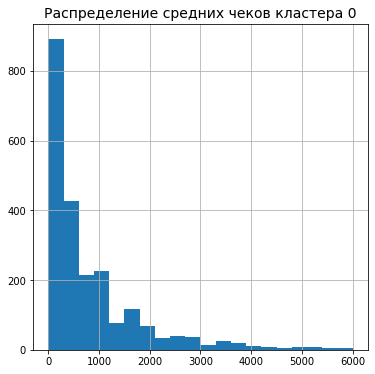

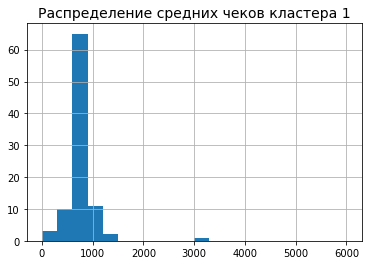

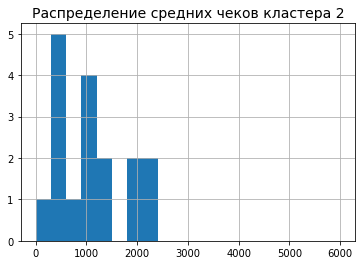

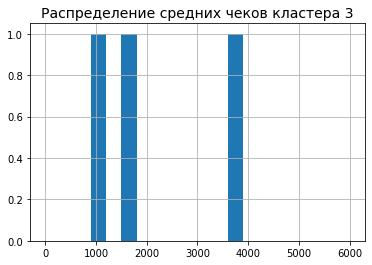

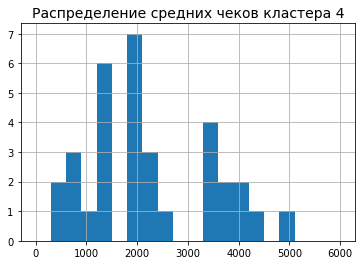

In [77]:
plt.figure(figsize=(6, 6))
for i in range(0,5):
    df_avg_receipt.query('cluster_km==@i')['summ'].hist(bins = 20, range = (1,6000));
    plt.title('Распределение средних чеков кластера '+str(i), fontsize = 14)
    plt.show();
    #plt.savefig('segments_dist.png', transparent=True)

Перед проведением теста оценим нормальность распределений стоимости заказов. 
- Распределение средних чеков нулевого кластера представляет собой нормальное распределение с датасетом, скошенным вправо.  Аналогично, первый кластер распределен нормально и тоже скошен вправо.
- Распределение средних чеков второго кластера похоже на нормальное, но после 3000 идут аномалии, предлагается избавиться от них.
- Распределение 4 кластера почти нормальное, необходимо удалить пик после 3000.

In [78]:
df_avg_receipt_0 = df_avg_receipt.query('cluster_km==0')

In [79]:
df_avg_receipt_1 = df_avg_receipt.query('cluster_km==1')

In [80]:
df_avg_receipt_2 = df_avg_receipt.query('cluster_km==2 and summ<3000')

In [81]:
df_avg_receipt_4 = df_avg_receipt.query('cluster_km==4 and summ<3000')

Сформируем датасеты для каждого кластера, чтобы проверить гипотезы.

In [82]:
avg_receipt_0_variance = np.var(df_avg_receipt_0['summ'], ddof=1)

In [83]:
avg_receipt_1_variance = np.var(df_avg_receipt_1['summ'], ddof=1)

In [84]:
avg_receipt_2_variance = np.var(df_avg_receipt_2['summ'], ddof=1)

In [85]:
avg_receipt_4_variance = np.var(df_avg_receipt_4['summ'], ddof=1)

Сравним дисперсии выборок средних чеков кластеров для того, чтобы решить какое значение присваивать параметру equal_var. Если дисперсии выборок равны, необходимо присваивать True, если различаются, то False.

In [86]:
avg_receipt_0_variance


1367794.5199572884

In [87]:
avg_receipt_4_variance

353005.9788098375

Для первой гипотезы параметр будет False, дисперсии не равны.

In [88]:
avg_receipt_1_variance

104790.87753075728

In [89]:
avg_receipt_2_variance

450328.53470588237

Для второй гипотезы параметр будет False, дисперсии не равны.

In [90]:
alpha = 0.05

Возьмем параметр уровня значимости alpha равным 5%, общепринятого порогового значения будет достаточно для проверки данных гипотез.

In [91]:
results_shapiro_0 = st.shapiro(df_avg_receipt_0['summ'])
p_value_shaporo_0 = results_shapiro_0[1]

In [92]:
if p_value_shaporo_0<alpha:
    print('Распределение не нормально')
else:
    print('Распределение нормально') 

Распределение не нормально


In [93]:
results_shapiro_1 = st.shapiro(df_avg_receipt_1['summ'])
p_value_shaporo_1 = results_shapiro_1[1]
if p_value_shaporo_1<alpha:
    print('Распределение не нормально')
else:
    print('Распределение нормально') 

Распределение не нормально


In [94]:
results_shapiro_2 = st.shapiro(df_avg_receipt_2['summ'])
p_value_shaporo_2 = results_shapiro_2[1]
if p_value_shaporo_2<alpha:
    print('Распределение не нормально')
else:
    print('Распределение нормально') 

Распределение нормально


In [95]:
results_shapiro_4 = st.shapiro(df_avg_receipt_4['summ'])
p_value_shaporo_4 = results_shapiro_4[1]
if p_value_shaporo_4<alpha:
    print('Распределение не нормально')
else:
    print('Распределение нормально') 

Распределение нормально


Проверим нормальность распределений средних чеков всех кластеров тестом Шапиро-Уилка. Распределение нулевого и первого кластера не нормально, применение теста Стьюдента может дать некорректные результаты. Предлагается применить непараметрический тест Манна-Уитни, он подходит для распределений, отличных от нормальных. 

In [96]:
results_1 = st.mannwhitneyu(df_avg_receipt_0['summ'], df_avg_receipt_4['summ'])
results_1.pvalue

2.1548752527916576e-07

In [97]:
if results_1.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Проведем тест Манна-Уитни для нулевого и четвертого кластеров. pvalue меньше 5%. Вывод - между средними чеками нулевого и четвертого кластера есть различия.

In [98]:
results_2 = st.mannwhitneyu(df_avg_receipt_1['summ'], df_avg_receipt_2['summ'])
results_2.pvalue

0.051084605597661335

In [99]:
if results_2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Аналогично проведем тест Манна-Уитни для первого и второго кластеров. pvalue больше 5%, но значение очень пограничное, очень незначительно отличается от принятого параметра уровня значимости. Предлагается согласиться с результатами теста и считать, что между средними чеками первого и второго кластеров нет значимых статистических различий.

## Общие выводы.

- В исследуемом датасете достаточно чистые данные. Нет пропусков и дубликатов строк. Поле date требовало приведения к формату даты-времени.

- Данные о покупках в датасете - с 1 октября 2018 по 31 октября 2019.

- В датасете находились данные о покупках 2 451 уникального покупателя.

- Исследовательский анализ данных выявил, что выше 6000 руб. покупки выглядят как аномальные(с большей вероятностью приобретены для перепродажи). Также выявлены пользователи с более чем 10 заказами за период исследования. Датасет для сегментации очищен от этих заказов и пользователей.

Сегментация выявила следующие категории пользователей:

- Кластер 0 - самый многочисленный, число уникальных покупателей - 2171. Количество сделанных заказов - 2291, что составляет примерно 1,1 заказ на покупателя. Средний чек покупателя - 1215 руб, что является почти самым невысоким значением (за исключением среднего чека покупателя из кластера 4). Среднее количество позиций товара в заказе - 4,4 шт., это второй по величине показатель. Категорийные предпочтения покупателей этого кластера разнообразны. Представленность в кластере всех категорий, количество покупателей в кластере, невысокий средний чек и количество позиций в заказе позволяют отнести покупателей этого кластера к сегменту "типичный повседневный разовый покупатель". Данный сегмент генерирует основную выручку магазина, но среднее количество заказов - 1,1 - не позволяет считать данного покупателя постоянным. Возможно, необходимы какие-либо маркетинговые мероприятия, чтобы убедить покупателей из этого сегмента делать повторные покупки, это благоприятно скажется на общей выручке магазина.

- Кластер 1 - достаточно немногочисленный, 74 покупателя. Средний чек этого кластера - 2865 руб, это один из самых высоких средних чеков. Количество заказов: 1,4 на покупателя, количество sku в заказе - 28,9 штук, самый высокий показатель. Лидирующая категория - растения, занимает 96,5% среди покупок кластера. По совокупности факторов типичный покупатель этого кластера похож на мелкооптового покупателя. Высокий средний чек и самое высокое значение количества заказов на покупателя позволяют считать клиента этого кластера постоянным и перспективным клиентом. Для увеличения выручки возможно будет целесообразно сделать персональное предложение о скидках за объем клиентам этого кластера.

- Кластер 2 - второй снизу по количеству покупателей, 33 покупателя. Генерируемая выручка - 95480 руб. Средний чек - самый высокий, 2893.3 руб. Количество заказов - 1,2 на покупателя. Среднее количество позиций в заказе на человека - 1,6. 96,2% покупок клиентами этого кластера - мебель. По совокупности характеристик можно отнести этот кластер к сегменту "разовые покупатели мебели". Возможно, будет целесообразно сделать покупателям данного кластера персональное предложение со скидкой мебели за вторую и последующую покупку.

- Кластер 3 - самый немногочисленный, содержит 17 покупателей. Количество заказов - 16. Выручка этого кластера самая маленькая, 21071 руб. Доминирующая категория - бытовая техника. Совокупность факторов позволяет идентифицировать этот сегмент покупателей как покупателей бытовой техники.

- Кластер 4 - второй по многочисленности, 92 покупателя. Выручка кластера - 83142 руб, но средний чек - самый низкий, 903 руб. Среднее количество покупок на клиента - 1,1. Доминирующая категория - товары для сада, 96,2%. По совокупности факторов можно идентифицировать данный сегмент как покупателей товаров для сада, не склонных к повторным покупкам. Возможно, имеет смысл сделать персональное предложение, стимулирующее клиентов данного кластера к повторным покупкам.

Кластерный анализ показал, что есть 2 пары схожих и значимых (в части выручки и количества покупателей) кластеров. Наиболее многочисленные кластеры - нулевой и четвертый - имеют схожие средние чеки (1215 руб. и 903 руб.). Два кластера с максимальным средним чеком - первый и второй - имеют практически идентичный средний чек (2865 и 2893 руб). Проведена проверка двух гипотез о идентичности средних чеков кластера 0 и 4 и средних чеков кластера 1 и 2. Гипотеза 1 об идентичности средних чеков кластеров 0 и 4 не подтвердилась, средние чеки данных кластеров различаются. Гипотеза об идентичности средних чеков кластеров 1 и 2 подтвердилась, между средними чеками этих кластеров нет значимых статистических различий.

Ссылка на презентацию:
https://drive.google.com/file/d/1AqGb8EKXXAl5IaIsDWby5txOllXYCs32/view?usp=sharing

Ссылка на дашборд:
https://public.tableau.com/views/ecommerce_dash/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link